<h1> Libraries </h1>

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split

from PIL import Image
from astropy.stats import circmean, circvar

from tqdm import tqdm
import sqlite3
import pickle
from scipy.linalg import svd
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.decomposition import TruncatedSVD 

#Models and Metrics
from sklearn.linear_model import SGDClassifier
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import randint as sp_randint
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold 
import xgboost as xgb
from lightgbm import LGBMClassifier
from prettytable import PrettyTable
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ParameterGrid
import datetime

<h1> Mounting with google drive if needed </h1>

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


<h1> Getting Data </h1>
<div>
Please make the data_train and data_test pickle files using Feature_Engineering Notebook and then Start with this notebook.

I ll suggest make the pickle files and load them in your google drive and then load them ysing pickle just like I have done in the below cell.

Please change the path if needed for loading the data.
</div>

In [2]:
data_train = pickle.load(open("/content/drive/MyDrive/data_train.pickle" , 'rb'))
data_test = pickle.load(open("/content/drive/MyDrive/data_test.pickle" , 'rb'))



data_test.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 4833292 entries, (3, 248) to (206208, 49621)
Data columns (total 47 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   up_unique_dow                int8   
 1   up_unique_hod                int8   
 2   up_unique_atc                int8   
 3   up_unique_reordered          int8   
 4   up_cumcount_on               int16  
 5   up_cumcount_dow              int16  
 6   up_cumcount_hod              int16  
 7   up_cumcount_dsp              float16
 8   up_cumcount_atc              int16  
 9   up_orders_cumcount           int8   
 10  up_orders_num                int8   
 11  up_orders_since_previous     int8   
 12  up_reordered                 int8   
 13  up_order_ratio               float16
 14  up_order_dow_score           float16
 15  up_order_hour_of_day_score   float16
 16  up_last_five                 float16
 17  up_last_five_ratio           float16
 18  max_orders                 

In [3]:
X = data_train.drop('reordered', axis=1)
y = data_train.reordered


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)
print("Training Dataset ---X_train:",X_train.shape , "with y_train",y_train.shape)
print("Test Dataset ---X_cv:",X_test.shape , "with y_cv",y_test.shape)
print()
print("We ll get the model with good accuracy using these datasets")
print("Then we ll predict for kaggle dataset")
print("="*50)
print("Dataset for which we have to predict Kaggle:",data_test.shape)

Training Dataset ---X_train: (5932262, 47) with y_train (5932262,)
Test Dataset ---X_cv: (2542399, 47) with y_cv (2542399,)

We ll get the model with good accuracy using these datasets
Then we ll predict for kaggle dataset
Dataset for which we have to predict Kaggle: (4833292, 47)


In [4]:
#Taken from Facebook Recomendation system case study
#Please run this cell for plotting confusion matrix for the classifiers

def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    
    A =(((C.T)/(C.sum(axis=1))).T)
    
    B =(C/C.sum(axis=0))
    plt.figure(figsize=(20,4))
    
    labels = [0,1]
    # representing A in heatmap format
    cmap=sns.light_palette("red")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

In [ ]:
#URL : https://www.kaggle.com/aikinogard/python-f1-score-function 
def f1_score_single(y_true, y_pred):
    print(type(y_pred))
    print(type(y_true))
    cross_size = len(int(y_true) & int(y_pred))
    if cross_size == 0: return 0.
    p = 1. * cross_size / len(y_pred)
    r = 1. * cross_size / len(y_true)
    return 2 * p * r / (p + r)
    
def f1_score(y_true, y_pred):
    return np.mean([f1_score_single(x, y) for x, y in zip(y_true, y_pred)])

<h1> Light GBM Classifier </h1>

<b>
<div>
 Please Run all the below cell for LGBM Classification 
 </div>

In [ ]:
hyperparameters = {
                  
                  "max_depth": [1,2,3,4,5,6,7,8,9,10],
                  "num_leaves":[2, 4, 8, 16, 32, 64, 128, 256, 512, 1024],
                  "learning_rate":[0.0001, 0.001, 0.01, 0.1, 1.0]
                  }

LGB = LGBMClassifier(random_state=10)

randomizedsearch = RandomizedSearchCV(LGB, hyperparameters , n_iter=5,cv=10,scoring='f1',random_state=66 , verbose = 5)

model = randomizedsearch.fit(X_train,y_train)

print('mean test scores',model.cv_results_['mean_test_score'])
print(model.best_estimator_)

Fitting 10 folds for each of 5 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] num_leaves=2, max_depth=3, learning_rate=0.0001 .................
[CV]  num_leaves=2, max_depth=3, learning_rate=0.0001, score=0.000, total=  26.4s
[CV] num_leaves=2, max_depth=3, learning_rate=0.0001 .................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   26.4s remaining:    0.0s


[CV]  num_leaves=2, max_depth=3, learning_rate=0.0001, score=0.000, total=  26.3s
[CV] num_leaves=2, max_depth=3, learning_rate=0.0001 .................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   52.7s remaining:    0.0s


[CV]  num_leaves=2, max_depth=3, learning_rate=0.0001, score=0.000, total=  26.3s
[CV] num_leaves=2, max_depth=3, learning_rate=0.0001 .................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.3min remaining:    0.0s


[CV]  num_leaves=2, max_depth=3, learning_rate=0.0001, score=0.000, total=  26.2s
[CV] num_leaves=2, max_depth=3, learning_rate=0.0001 .................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  1.8min remaining:    0.0s


[CV]  num_leaves=2, max_depth=3, learning_rate=0.0001, score=0.000, total=  26.2s
[CV] num_leaves=2, max_depth=3, learning_rate=0.0001 .................
[CV]  num_leaves=2, max_depth=3, learning_rate=0.0001, score=0.000, total=  26.4s
[CV] num_leaves=2, max_depth=3, learning_rate=0.0001 .................
[CV]  num_leaves=2, max_depth=3, learning_rate=0.0001, score=0.000, total=  26.3s
[CV] num_leaves=2, max_depth=3, learning_rate=0.0001 .................
[CV]  num_leaves=2, max_depth=3, learning_rate=0.0001, score=0.000, total=  26.3s
[CV] num_leaves=2, max_depth=3, learning_rate=0.0001 .................
[CV]  num_leaves=2, max_depth=3, learning_rate=0.0001, score=0.000, total=  26.3s
[CV] num_leaves=2, max_depth=3, learning_rate=0.0001 .................
[CV]  num_leaves=2, max_depth=3, learning_rate=0.0001, score=0.000, total=  26.3s
[CV] num_leaves=128, max_depth=2, learning_rate=0.1 ..................
[CV]  num_leaves=128, max_depth=2, learning_rate=0.1, score=0.264, total=  28.7s
[

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed: 24.2min finished


mean test scores [0.         0.26483502 0.         0.         0.        ]
LGBMClassifier(max_depth=2, num_leaves=128, random_state=10)


In [ ]:
clf = LGBMClassifier(max_depth=2, num_leaves=128, random_state=10)

clf.fit(X_train,y_train)


#Saving 
#filename = 'LGB_model.sav'
#pickle.dump(clf, open(filename, 'wb'))

LGBMClassifier(max_depth=2, num_leaves=128, random_state=10)

Confusion Matrix for Test-


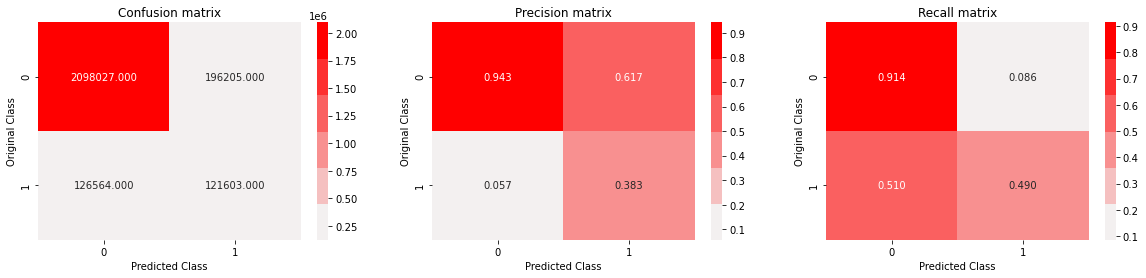

In [ ]:
y_pred = (clf.predict_proba(X_test)[:, 1] >= 0.21).astype('int')
#y_pred
print("Confusion Matrix for Test-")
plot_confusion_matrix(y_test,y_pred)

In [ ]:
#Please run the cell with plot_confusion_matrix funtion first then run this cell

y_train_pred =(clf.predict_proba(X_train)[:, 1] >= 0.21).astype('int')
print("Training F1 Score:", metrics.f1_score(y_train , y_train_pred))
print("Test F1 Score:",metrics.f1_score(y_test , y_pred))

Training F1 Score: 0.42983525293466585
Test F1 Score: 0.4297115596978665


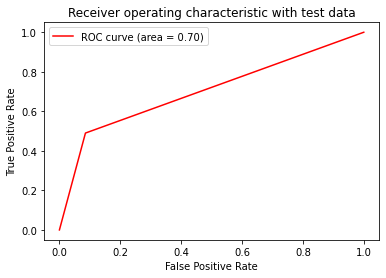

In [ ]:
fpr,tpr,ths = roc_curve(y_test,y_pred)
auc_sc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='red',label='ROC curve (area = %0.2f)' % auc_sc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic with test data')
plt.legend()
plt.show()

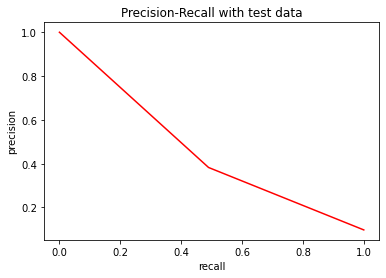

Area Under this curve :  0.36359686763080745


In [ ]:
precision, recall, _ = metrics.precision_recall_curve(y_test, y_pred)
plt.plot((recall),(precision), color='red')
plt.xlabel('recall')
plt.ylabel('precision')
plt.title('Precision-Recall with test data')
plt.show()

print("Area Under this curve : ",np.trapz(recall,precision))

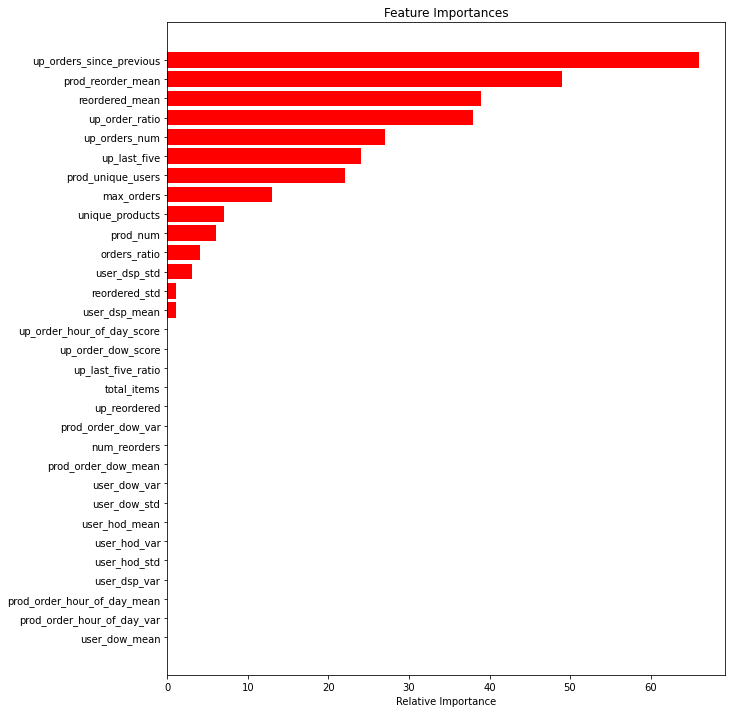

In [ ]:
features = X_train.columns
importances = clf.feature_importances_
indices = (np.argsort(importances))
plt.figure(figsize=(10,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='r', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

<h1> Getting the best Threshold For LGBM</h1>

In [ ]:
thresholds = clf.predict_proba(X_test)[:, 1]

100%|██████████| 13/13 [01:05<00:00,  5.04s/it]


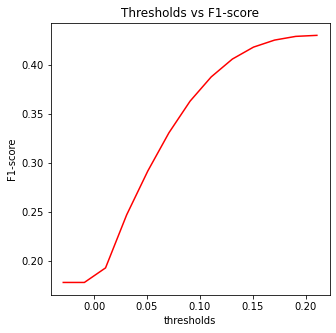

In [ ]:
thresholds = clf.predict_proba(X_test)[:, 1]
f1_scores = []
values = np.arange(np.mean(thresholds)-np.std(thresholds) , np.mean(thresholds) +np.std(thresholds)  , 0.02)

for value in tqdm(values):
    y_pred = (clf.predict_proba(X_test)[:, 1] >= value).astype('int')
    f1_scores.append(metrics.f1_score(y_test , y_pred))

plt.figure(figsize=(5,5))
sns.lineplot(values , f1_scores , color = "red")
plt.xlabel("thresholds")
plt.ylabel("F1-score")
plt.title("Thresholds vs F1-score")

plt.show()
    

<h2> Observation </h2>
<br>
<b>
<div>
    i.e 0.21 is an idle value for thresholds
    
 </div>

<h1> Fitting and Saving the model <h1>

In [ ]:
clf = LGBMClassifier(max_depth=2, num_leaves=128, random_state=10)

#fitting on whole data set.
clf.fit(X,y)


#Saving 
filename = 'LGBnew_model.sav'
pickle.dump(clf, open(filename, 'wb'))

<h1> Catboost Classifier </h1>

<div> 
<b> 
Please Run All the cells below for Catboost Classifier 
</div>

In [11]:
pip install catboost

     |████████████████████████████████| 66.3MB 68kB/s 


In [6]:
from catboost import CatBoostClassifier
cat_features = list(range(0, X.shape[1]))
print(cat_features)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46]


<h1> Tuning of Catboost Classifier </h1>

In [ ]:
#For learning Rate and iterations
learning_rate = [0.0001, 0.001, 0.01, 0.1, 1.0]
iterations = [100 , 300 , 600 , 1000]
prec_recall_area = []
dict_of_values = {}

#Loop for the Tuning
for lr in learning_rate:
    for ite in iterations:
        clf = CatBoostClassifier(
        iterations = ite,
        learning_rate=lr,
        task_type = "GPU",
        verbose = False)

        clf.fit(X_train, list(map(int , y_train)))

        y_pred = (clf.predict_proba(X_test)[:, 1] >= 0.21).astype('int')
        precision, recall, _ = metrics.precision_recall_curve(y_test, y_pred)
        prec_recall_area.append(np.trapz(recall,precision))
        print("With lr:",lr,",with iter:",ite , ",area is:" ,np.trapz(recall,precision))


With lr: 0.0001 ,with iter: 100 ,area is: 0.45119432473030396
With lr: 0.0001 ,with iter: 300 ,area is: 0.45119432473030396
With lr: 0.0001 ,with iter: 600 ,area is: 0.45119432473030396
With lr: 0.0001 ,with iter: 1000 ,area is: 0.45119432473030396
With lr: 0.001 ,with iter: 100 ,area is: 0.45119432473030396
With lr: 0.001 ,with iter: 300 ,area is: 0.45119432473030396
With lr: 0.001 ,with iter: 600 ,area is: 0.4297141326144864
With lr: 0.001 ,with iter: 1000 ,area is: 0.387499772722357
With lr: 0.01 ,with iter: 100 ,area is: 0.38767892975747553
With lr: 0.01 ,with iter: 300 ,area is: 0.3666813357650374
With lr: 0.01 ,with iter: 600 ,area is: 0.3686419509068298
With lr: 0.01 ,with iter: 1000 ,area is: 0.37083596923725004
With lr: 0.1 ,with iter: 100 ,area is: 0.3706101446593683
With lr: 0.1 ,with iter: 300 ,area is: 0.3730193264960253
With lr: 0.1 ,with iter: 600 ,area is: 0.37364835656871787
With lr: 0.1 ,with iter: 1000 ,area is: 0.37417276460286625
With lr: 1.0 ,with iter: 100 ,area 

In [ ]:
#For depth
depth = [1,2,3,4,5,6,7,8,9,10]

#Loop for the tuning
for d in depth:
    clf = CatBoostClassifier(
        iterations = 500, #from above and did some iterations
        depth = d,
        learning_rate=0.01, #from above and did some iterations
        task_type = "GPU",
        verbose = False)

    clf.fit(X_train, list(map(int , y_train)))

    y_pred = (clf.predict_proba(X_test)[:, 1] >= 0.21).astype('int')
    precision, recall, _ = metrics.precision_recall_curve(y_test, y_pred)
    prec_recall_area.append(np.trapz(recall,precision))
    print("With d",d , ",area is:" ,np.trapz(recall,precision))


With d 1 ,area is: 0.35464173737421
With d 2 ,area is: 0.3591587102324172
With d 3 ,area is: 0.3623822709987313
With d 4 ,area is: 0.3645658883372689
With d 5 ,area is: 0.3662003257206519
With d 6 ,area is: 0.3678237258305652
With d 7 ,area is: 0.36889634896333057
With d 8 ,area is: 0.3700225974020339
With d 9 ,area is: 0.37071846968685707
With d 10 ,area is: 0.3711568880859637


In [ ]:
#for bagging temperature
temperature = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]

#Loop for the tuning
for temp in temperature:
    clf = CatBoostClassifier(
        iterations = 500, 
        depth = 14, #From above and did some iterations
        learning_rate=0.01,
        bagging_temperature = temp,
        task_type = "GPU",
        verbose = False)

    clf.fit(X_train, list(map(int , y_train)))

    y_pred = (clf.predict_proba(X_test)[:, 1] >= 0.21).astype('int')
    precision, recall, _ = metrics.precision_recall_curve(y_test, y_pred)
    prec_recall_area.append(np.trapz(recall,precision))
    print("With temp:",temp , ",area is:" ,np.trapz(recall,precision))

With temp: 0.1 ,area is: 0.3726099205264942
With temp: 0.2 ,area is: 0.372483256570864
With temp: 0.3 ,area is: 0.3724781358206065
With temp: 0.4 ,area is: 0.3725242883815896
With temp: 0.5 ,area is: 0.37251957955704645
With temp: 0.6 ,area is: 0.3725259863997444
With temp: 0.7 ,area is: 0.372415931119544
With temp: 0.8 ,area is: 0.3723601502387831


In [13]:
#Taking the best one.
#lr = 0.01,iter : 500 , depth: 14 , bagging_temperature : 0.1
clf = CatBoostClassifier(
    iterations = 1000, 
    random_strength = 0.5,
    depth = 14,
    learning_rate=0.01,
    bagging_temperature = 0.1,
    task_type = "GPU",
    verbose = 3
)

#Mapping y into int format---- [0.0 , 1.0]---> [0,1] (Essential for catboost classifier)
clf.fit(X_train, list(map(int , y_train)))


0:	learn: 0.6806261	total: 442ms	remaining: 7m 21s
3:	learn: 0.6448368	total: 1.53s	remaining: 6m 20s
6:	learn: 0.6120106	total: 2.64s	remaining: 6m 13s
9:	learn: 0.5822676	total: 3.73s	remaining: 6m 9s
12:	learn: 0.5548349	total: 4.84s	remaining: 6m 7s
15:	learn: 0.5301075	total: 5.84s	remaining: 5m 59s
18:	learn: 0.5074424	total: 6.92s	remaining: 5m 57s
21:	learn: 0.4866210	total: 8.01s	remaining: 5m 56s
24:	learn: 0.4676638	total: 9.09s	remaining: 5m 54s
27:	learn: 0.4503251	total: 10.2s	remaining: 5m 53s
30:	learn: 0.4344308	total: 11.1s	remaining: 5m 46s
33:	learn: 0.4199493	total: 12.2s	remaining: 5m 45s
36:	learn: 0.4065720	total: 13.3s	remaining: 5m 45s
39:	learn: 0.3944727	total: 14.4s	remaining: 5m 45s
42:	learn: 0.3832383	total: 15.5s	remaining: 5m 44s
45:	learn: 0.3730587	total: 16.6s	remaining: 5m 44s
48:	learn: 0.3637481	total: 17.7s	remaining: 5m 43s
51:	learn: 0.3551592	total: 18.8s	remaining: 5m 43s
54:	learn: 0.3471480	total: 19.9s	remaining: 5m 42s
57:	learn: 0.33984

100%|██████████| 27/27 [10:45<00:00, 23.89s/it]


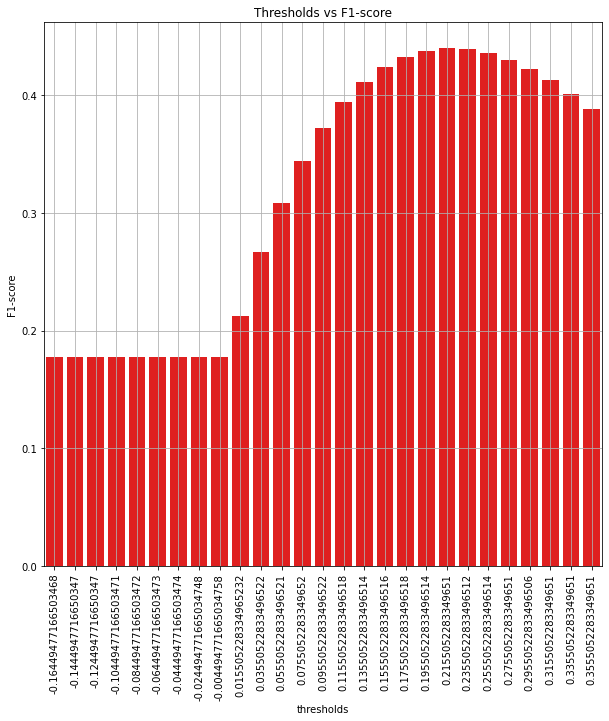

In [ ]:
thresholds = clf.predict_proba(X_test)[:, 1]
f1_scores = []
values = np.arange(np.mean(thresholds)-(2*np.std(thresholds)) , np.mean(thresholds) +(2*np.std(thresholds))  , 0.02)
for value in tqdm(values):
    y_pred = (clf.predict_proba(X_test)[:, 1] >= value).astype('int')
    f1_scores.append(metrics.f1_score(y_test , y_pred))

plt.figure(figsize=(10,10))
sns.barplot(values , f1_scores , color = "red")
plt.xlabel("thresholds")
plt.ylabel("F1-score")
plt.title("Thresholds vs F1-score")
plt.grid(True)
plt.xticks(rotation = 90)

plt.show()

Confusion Matrix for Test-


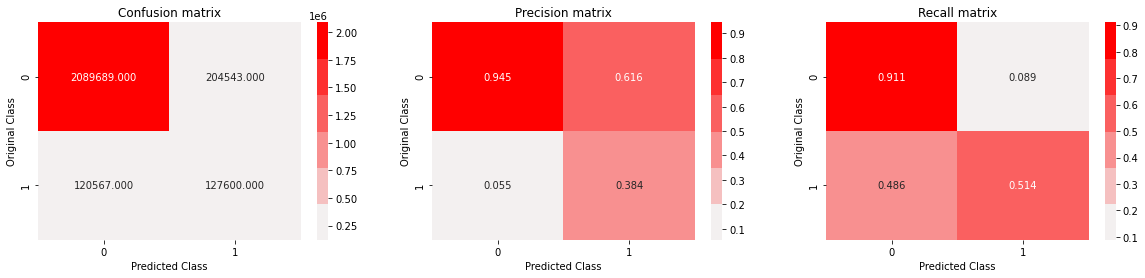

In [14]:
#Please run the cell with plot_confusion_matrix funtion first then run this cell

y_pred = (clf.predict_proba(X_test)[:, 1] >= 0.21).astype('int')
#y_pred
print("Confusion Matrix for Test-")
plot_confusion_matrix(y_test,y_pred)

In [15]:
y_train_pred =(clf.predict_proba(X_train)[:, 1] >= 0.21).astype('int')
print("Training F1 Score:", metrics.f1_score(y_train , y_train_pred))
print("Test F1 Score:",metrics.f1_score(y_test , y_pred))

Training F1 Score: 0.4604873389601336
Test F1 Score: 0.4397649532146611


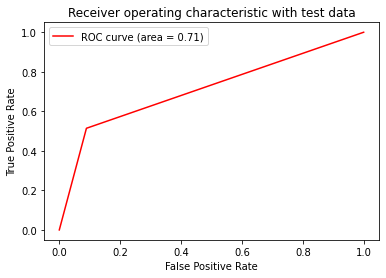

In [16]:
fpr,tpr,ths = roc_curve(y_test,y_pred)
auc_sc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='red',label='ROC curve (area = %0.2f)' % auc_sc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic with test data')
plt.legend()
plt.show()

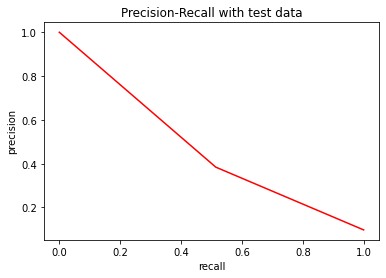

Area Under this curve :  0.3752708015847912


In [17]:
precision, recall, _ = metrics.precision_recall_curve(y_test, y_pred)
plt.plot((recall),(precision), color='red')
plt.xlabel('recall')
plt.ylabel('precision')
plt.title('Precision-Recall with test data')
plt.show()

print("Area Under this curve : ",np.trapz(recall,precision))

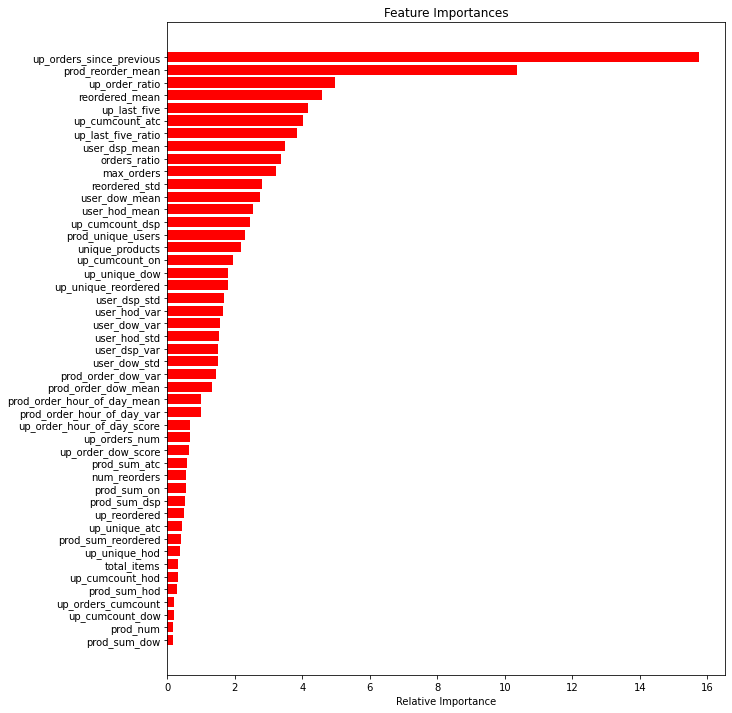

In [18]:
features = X_train.columns
importances = clf.feature_importances_
indices = (np.argsort(importances))
plt.figure(figsize=(10,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='r', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [8]:
#fitting in entire data
clf = CatBoostClassifier(
    iterations = 1000, 
    random_strength = 0.5,
    depth = 14,
    learning_rate=0.01,
    bagging_temperature = 0.1,
    task_type = "GPU",
    verbose = 100
)

print("Fitting the the model on whole data....")
#Mapping y into int format---- [0.0 , 1.0]---> [0,1] (Essential for catboost classifier)
clf.fit(X, list(map(int , y)))
print("Fitting done.")
#Saving 
print()
print("Saving the model...")
filename = 'CATBOOST.sav'
pickle.dump(clf, open(filename, 'wb'))

print("Saved...")

Fitting the the model on whole data....
0:	learn: 0.6806174	total: 490ms	remaining: 8m 9s
100:	learn: 0.2809204	total: 43.3s	remaining: 6m 25s
200:	learn: 0.2518466	total: 1m 26s	remaining: 5m 42s
300:	learn: 0.2476303	total: 2m 10s	remaining: 5m 4s
400:	learn: 0.2462787	total: 2m 55s	remaining: 4m 22s
500:	learn: 0.2451952	total: 3m 40s	remaining: 3m 39s
600:	learn: 0.2441689	total: 4m 26s	remaining: 2m 56s
700:	learn: 0.2432228	total: 5m 10s	remaining: 2m 12s
800:	learn: 0.2422836	total: 5m 55s	remaining: 1m 28s
900:	learn: 0.2413235	total: 6m 39s	remaining: 43.9s
999:	learn: 0.2404339	total: 7m 23s	remaining: 0us
Fitting done.

Saving the model...
Saved...


<h1> MLP Classifier </h1>

<b>
<div>
Please run all the cells below for MLP Classifier </div>

Iteration 1, loss = inf
Iteration 2, loss = inf
Iteration 3, loss = inf
Iteration 4, loss = inf
Iteration 5, loss = inf
Iteration 6, loss = inf
Iteration 7, loss = 0.26353480
Iteration 8, loss = 0.26291831
Iteration 9, loss = 0.26298802
Iteration 10, loss = 0.26272234
Iteration 11, loss = 0.26261478
Iteration 12, loss = 0.26240279
Iteration 13, loss = 0.26249572
Iteration 14, loss = 0.26246979
Iteration 15, loss = 0.26240699
Iteration 16, loss = 0.26253592
Iteration 17, loss = 0.26255726
Iteration 18, loss = 0.26219054
Iteration 19, loss = 0.26244684
Iteration 20, loss = 0.26235919
Iteration 21, loss = 0.26239644
Iteration 22, loss = 0.26237850
Iteration 23, loss = 0.26242757
Iteration 24, loss = 0.26225759
Iteration 25, loss = 0.26220967
Iteration 26, loss = 0.26249003
Iteration 27, loss = 0.26230704
Iteration 28, loss = 0.26237086
Iteration 29, loss = 0.26239389
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Confusion Matrix for Test-


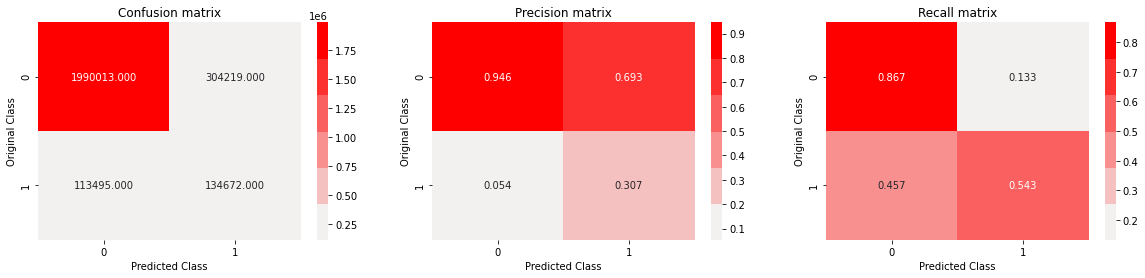


Training F1 Score: 0.39273597710435526
Test F1 Score: 0.3920251274273787


In [ ]:
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(hidden_layer_sizes=(100, ), activation='relu', solver='adam', 
                    alpha=0.0001, batch_size='auto', learning_rate='constant', learning_rate_init=0.001, power_t=0.5, 
                    max_iter=200, shuffle=True, random_state=None, tol=0.0001, warm_start=False, momentum=0.9, 
                    nesterovs_momentum=True, early_stopping=False, validation_fraction=0.1, beta_1=0.9, beta_2=0.999, epsilon=1e-08, 
                    n_iter_no_change=10 , verbose = True)

clf.fit(X_train, y_train)

y_pred = (clf.predict_proba(X_test)[:, 1] >= 0.21).astype('int')
#y_pred
print("Confusion Matrix for Test-")
plot_confusion_matrix(y_test,y_pred)

print()


y_train_pred =(clf.predict_proba(X_train)[:, 1] >= 0.21).astype('int')
print("Training F1 Score:", metrics.f1_score(y_train , y_train_pred))
print("Test F1 Score:",metrics.f1_score(y_test , y_pred))

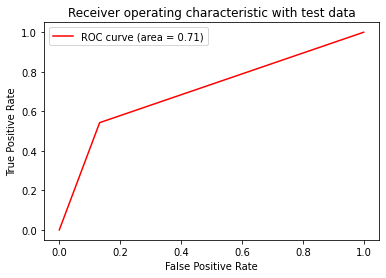

In [ ]:
fpr,tpr,ths = roc_curve(y_test,y_pred)
auc_sc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='red',label='ROC curve (area = %0.2f)' % auc_sc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic with test data')
plt.legend()
plt.show()

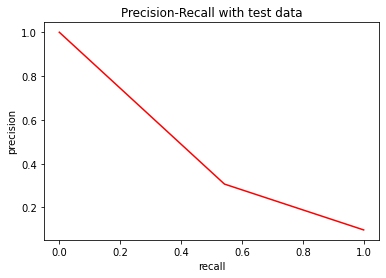

Area Under this curve :  0.34946557958308333


In [ ]:
precision, recall, _ = metrics.precision_recall_curve(y_test, y_pred)
plt.plot((recall),(precision), color='red')
plt.xlabel('recall')
plt.ylabel('precision')
plt.title('Precision-Recall with test data')
plt.show()

print("Area Under this curve : ",np.trapz(recall,precision))

<h1> Neural Network for the classification </h1>

<h2> Libraries for NN's </h2>

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, Flatten, MaxPooling1D
import tensorflow as tf
import random as rn

<h2> Making the dataset for neural networks </h2>

In [ ]:
print("preparing the datasets...")
x_train = X_train.values.reshape(X_train.shape[0], X_train.shape[1], 1)
x_test = X_test.values.reshape(X_test.shape[0], X_test.shape[1], 1)

print()
print("Training shape---> ",x_train.shape)
print("Test shape    ---> ",x_test.shape)

print("..Done")

preparing the datasets...

Training shape--->  (5932262, 41, 1)
Test shape    --->  (2542399, 41, 1)
..Done


<h1> Conv1D with dense layers </h1>

In [ ]:
tf.keras.backend.clear_session()

np.random.seed(0)
rn.seed(0)


model = Sequential()
model.add(Conv1D(filters=2, kernel_size=10 ,strides=10, activation="relu", input_shape=(41, 1),kernel_initializer='he_uniform'))

model.add(Conv1D(filters=1, kernel_size=1,activation="relu",kernel_initializer='he_uniform'))

model.add(tf.keras.layers.BatchNormalization())

model.add(Dense(64, activation="relu",kernel_initializer='he_uniform'))

model.add(Dense(32, activation="relu",kernel_initializer='he_uniform'))

model.add(tf.keras.layers.BatchNormalization())

model.add(Dense(16, activation="relu",kernel_initializer='he_uniform'))

model.add(Dense(8, activation="relu",kernel_initializer='he_uniform'))

model.add(MaxPooling1D(padding='valid'))

model.add(Flatten())

model.add(Dense(1, activation = 'sigmoid'))
opt = tf.optimizers.Adam(learning_rate=0.0001)
model.compile(loss = 'binary_crossentropy', optimizer = opt,metrics=['accuracy'])
print(model.summary())


#model.fit(x_train, y_train, batch_size=16,epochs=100, verbose=2)
model.fit(x_train, np.array(list(map(int , y_train))), batch_size=16,epochs=5,validation_data=(x_test,np.array(list(map(int , y_test)))),verbose=2)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 4, 2)              22        
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 4, 1)              3         
_________________________________________________________________
batch_normalization (BatchNo (None, 4, 1)              4         
_________________________________________________________________
dense (Dense)                (None, 4, 64)             128       
_________________________________________________________________
dense_1 (Dense)              (None, 4, 32)             2080      
_________________________________________________________________
batch_normalization_1 (Batch (None, 4, 32)             128       
_________________________________________________________________
dense_2 (Dense)              (None, 4, 16)             5

In [ ]:
y_pred = model.predict(x_test)
#print(y_pred)

#reshaping the output
y_pred = np.reshape(y_pred , y_pred.shape[0])

print(y_pred)

[0.06632225 0.06052536 0.03526392 ... 0.04061966 0.03941361 0.06866539]


100%|██████████| 18/18 [02:13<00:00,  7.41s/it]


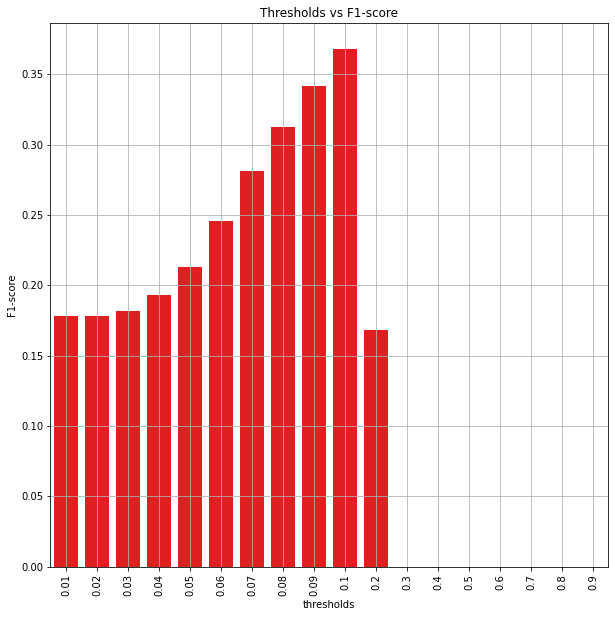

In [ ]:
#getting best threshold for best F1-Score
y_pred_ = y_pred
thresholds = [0.01 , 0.02 , 0.03 , 0.04 , 0.05 , 0.06 , 0.07 , 0.08 , 0.09 , 0.1 , 0.2 , 0.3 , 0.4 , 0.5 , 0.6 , 0.7 , 0.8 , 0.9]
f1_scores = []


for threshold in tqdm(thresholds):
    y_pred_temp = [1 if i > threshold else 0 for i in y_pred_]
    f1_scores.append(metrics.f1_score(y_test , y_pred_temp))

plt.figure(figsize=(10,10))
sns.barplot(thresholds , f1_scores , color = "red")
plt.xlabel("thresholds")
plt.ylabel("F1-score")
plt.title("Thresholds vs F1-score")
plt.xticks(rotation = 90)
plt.grid(True)

plt.show()

<h1> Only Dense Layers<h1>

<div>
I ll suggest not to run this cell but i have kept it for reference as it was a 8th winner solution network but dont know why It didnt work out for me
</div>

In [ ]:
tf.keras.backend.clear_session()

np.random.seed(0)
rn.seed(0)


models = Sequential()
models.add(Dense(1024, activation="relu",input_shape=(41, 1), input_dim=3, kernel_initializer='lecun_uniform')) 
models.add(tf.keras.layers.BatchNormalization())    
models.add(tf.keras.layers.Dropout(0.5))  
models.add(Dense(512, activation='relu',kernel_initializer='lecun_uniform'))
models.add(tf.keras.layers.BatchNormalization())    
models.add(tf.keras.layers.Dropout(0.4)) 
models.add(Flatten()) 
models.add(Dense(1, activation='sigmoid' ,  kernel_initializer='lecun_uniform'))
   
opt = tf.optimizers.Adam(lr=0.01)
models.compile(loss='binary_crossentropy', optimizer=opt,metrics=['accuracy'])
models.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 41, 1024)          2048      
_________________________________________________________________
batch_normalization (BatchNo (None, 41, 1024)          4096      
_________________________________________________________________
dropout (Dropout)            (None, 41, 1024)          0         
_________________________________________________________________
dense_1 (Dense)              (None, 41, 512)           524800    
_________________________________________________________________
batch_normalization_1 (Batch (None, 41, 512)           2048      
_________________________________________________________________
dropout_1 (Dropout)          (None, 41, 512)           0         
_________________________________________________________________
flatten (Flatten)            (None, 20992)             0

In [ ]:
#Fitting
models.fit(x_train, np.array(list(map(int , y_train))), batch_size=16,epochs=5, verbose=2)

Epoch 1/5
370767/370767 - 1175s - loss: 0.7480 - accuracy: 0.8455
Epoch 2/5
370767/370767 - 1174s - loss: 0.6780 - accuracy: 0.8484
Epoch 3/5
370767/370767 - 1176s - loss: 0.6575 - accuracy: 0.8496
Epoch 4/5
370767/370767 - 1167s - loss: 0.6429 - accuracy: 0.8506
Epoch 5/5
370767/370767 - 1170s - loss: 0.6540 - accuracy: 0.8500


In [ ]:
y_pred = models.predict(x_test)
#print(y_pred)
y_pred = np.reshape(y_pred , y_pred.shape[0])

print(y_pred)

[0.00030363 0.00048767 0.00031042 ... 0.00045346 0.00036042 0.00049601]


100%|██████████| 4/4 [00:28<00:00,  7.17s/it]


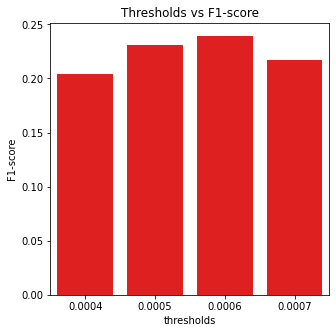

In [ ]:
#getting best threshold
y_pred_ = y_pred
thresholds = [0.0004 , 0.0005 , 0.0006 , 0.0007]
f1_scores = []
#values = np.arange(np.mean(thresholds)-np.std(thresholds) , np.mean(thresholds) +np.std(thresholds)  , 0.02)

for threshold in tqdm(thresholds):
    y_pred_temp = [1 if i > threshold else 0 for i in y_pred_]
    f1_scores.append(metrics.f1_score(y_test , y_pred_temp))

plt.figure(figsize=(5,5))
sns.barplot(thresholds , f1_scores , color = "red")
plt.xlabel("thresholds")
plt.ylabel("F1-score")
plt.title("Thresholds vs F1-score")

plt.show()
    


<h1> Making the Prediction for data test </h1>

<div>
Guide to make the Prediction
<ol>
<li>Set the threshold</li>
<li>if classifiying with the use of neural network run the cell with     "#for neural networks"</li>

<li> if classififying using Classifier the run the cell with "#for Classifiers"</li>

In [ ]:
threshold = 0.21  # 0.1 for conv1d-NN and 0.0006 for dense-NN

In [ ]:
#For neural networks
#threshold = 0.1
test = data_test.values.reshape(data_test.shape[0], data_test.shape[1], 1)
y_pred = model.predict(test)
y_pred = np.reshape(y_pred , y_pred.shape[0])

#taking the threshold and getting the values
y_pred_test = [1 if i > threshold else 0 for i in y_pred]

In [9]:
#For Classifiers

threshold = 0.22
y_pred_test = (clf.predict_proba(data_test)[:, 1] >= 0.21).astype('int')
#y_pred_test

<h1> Making the submission file </h1>

<b>
<div> 
To make the submission file please run all the cells below.
</div>

In [10]:
data_test['prediction'] = y_pred_test
data_test.head()

up_unique_dow  ...  prediction
user_id product_id                 ...            
3       248                     1  ...           0
        1005                    1  ...           0
        1819                    2  ...           0
        7503                    1  ...           0
        8021                    1  ...           0

[5 rows x 48 columns]

In [11]:
final = data_test.reset_index()
# Keep only the required columns to create our submission file (for chapter 6)
final = final[['product_id', 'user_id', 'prediction']]


final.head()

,product_id,user_id,prediction
0,248,3,0
1,1005,3,0
2,1819,3,0
3,7503,3,0
4,8021,3,0


In [12]:
#Creating a submission file
orders = pd.read_csv('/content/drive/MyDrive/orders.csv')
orders_test = orders.loc[orders.eval_set == 'test', ['user_id', 'order_id']]
orders_test.head()

,user_id,order_id
38,3,2774568
44,4,329954
53,6,1528013
96,11,1376945
102,12,1356845


In [13]:
final = final.merge(orders_test, on='user_id', how='left')
final.head()

,product_id,user_id,prediction,order_id
0,248,3,0,2774568
1,1005,3,0,2774568
2,1819,3,0,2774568
3,7503,3,0,2774568
4,8021,3,0,2774568


In [14]:
#remove user_id column
final = final.drop('user_id', axis=1)

In [15]:
#convert product_id as integer
final['product_id'] = final.product_id.astype(int)

## Remove all unnecessary objects
del orders
del orders_test

final.head()

,product_id,prediction,order_id
0,248,0,2774568
1,1005,0,2774568
2,1819,0,2774568
3,7503,0,2774568
4,8021,0,2774568


In [ ]:
#Cleaning
#del x_train
#del x_test
#del y_pred

In [16]:
# URL : https://www.kaggle.com/errolpereira/light-gradient-boosting
d = dict()
for row in tqdm(final.itertuples()):
    if row.prediction== 1:
        try:
            d[row.order_id] += ' ' + str(row.product_id)
        except:
            d[row.order_id] = str(row.product_id)

for order in tqdm(final.order_id):
    if order not in d:
        d[order] = 'None'

4833292it [00:04, 1057047.84it/s]
100%|██████████| 4833292/4833292 [00:01<00:00, 2939981.57it/s]


In [17]:
#Convert the dictionary into a DataFrame
sub = pd.DataFrame.from_dict(d, orient='index')

#Reset index
sub.reset_index(inplace=True)
#Set column names
sub.columns = ['order_id', 'products']

sub.head()

,order_id,products
0,2774568,17668 18599 21903 23650 39190 43961 47766
1,1528013,21903 38293
2,1376945,8309 13176 14947 27959 28465 33572 34658 44632
3,1356845,7076 10863 11520 13176 14992 22959 28134
4,2161313,196 10441 11266 12427 14715 27839 37710


In [18]:
sub.to_csv("submission_csv_28.csv" , index = False)

<h1> Submision on Kaggle </h1>

<div>
I use to get the score for the submission and load it in google colab space and the just loaded the image usling Pillow Image.

You can follow the same

</div>

<h2> Score of Catboost Classifier </h2>

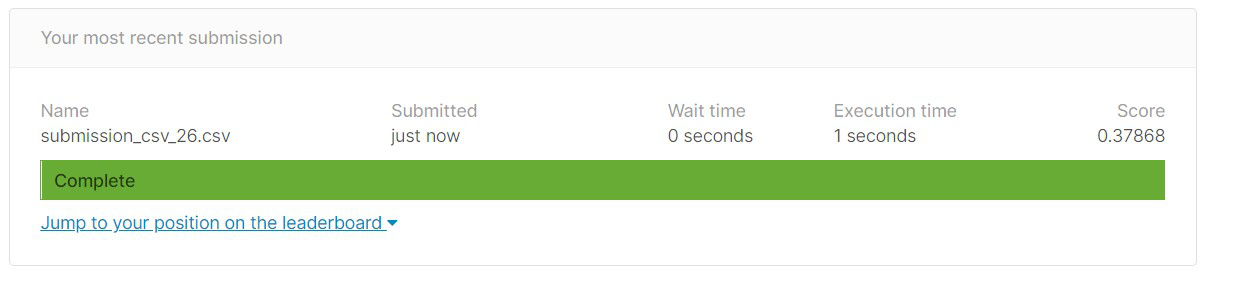

In [4]:
img = Image.open("MY_KAGGLE_SUBMISSION_SCORE.jpg")
img